# Sentiment Analysis (NLP, Logistic Regression, Bernoulli NB)



## Introduction
This notebook will compare the use of two NLP techniques, Count Vectorizor and TF-IDF Vectorizer, and two classification models, Logistic Regression and Bernoulli NB in sentiment analysis. I'll give detailed explanation on which model performs better and why.

Data: movie ratings from IMDB.com

The data consists of the text of a movie review and a target variable which tells us whether the reviewer had a positive feeling towards the movie (equivalent to rating the movie between 7 and 10) or a negative feeling (rating the movie between 1 and 4). Neutral reactions are not included in the data.

### Part 1: Naive Bayes

We know that Naive Bayes classifier works by calculating the conditional probabilities of each feature, $e_i$, occuring with each class $c$ and treating them independently. This results in the probability of a certain class occuring given a set of features, or a piece of evidence, $E$, as

$$P(c \mid E) = \frac{p(e_1 \mid c) \cdot p(e_2 \mid c) \cdot \cdot \cdot p(e_k \mid c) \cdot p(c)}{p(E)}.$$

The conditional probability of each piece of evidence occuring with a given class is given by

$$P(e_i \mid c) = \frac{\text{count}(e_i, c)}{\text{count}(c)}.$$

In the above equation $\text{count}(e_i, c)$ is the number of documents in a given class that contain feature $e_i$ and $\text{count}(c)$ is the number of documents that belong to class $c$. 

A common variation of the above is to use Laplace (sometimes called +1) smoothing. Recall the use of Laplace smoothing introduced toward the end of Chapter 3 in the section Probability Estimation. This is done in sklearn by setting `alpha=1` in the `BernoulliNB()` function (this is also the default behavior). The result of Laplace smoothing will slightly change the conditional probabilities,

$$P(e_i \mid c) = \frac{\text{count}(e_i, c) + 1}{\text{count}(c) + 2}.$$

**Why should we use Laplace smoothing?**

Laplace smoothing is a technique to smooth the probability estimation of categorical data. It is useful because it introduces some correction or regularization to our probability measures and helps avoid having 0 probability for some classes. Extreme values like 0 probability can easily distort our class probability estimation since it would turn everything into 0 (see the example below). When our count (e,c) gets larger and larger, the overall conditional probability estimation will converge to the original estimation. The effects of Laplace smoothing on our probability estimation is demonstrated in figure 3-16 (p.74, *Data Science for Business*). 

Looking at this from a bias-variance tradeoff, anytime we add a correction term, we introduce more bias but help lower the variance of prediction errors. We would using Laplace smoothing when we know that we will get more information by including these sparse instances, thus improve our predictions and reduce variance. In that case, the resulted bias is acceptable. An example in which we have to use Laplace smoothing is when some of our class or potentially important features have very sparse data. Let's say we have a movie review data set and out of 500 negative reviews, the word *'trash'* occurs twice, once in a negative review in the training set and once in a positive review in the test set. Thus, when training our data, we will get *count(trash, positive) = 0* and thus *p(trash|positive) = 0*, which leads to *p(positive| trash and other terms) = 0* no matter what. This is similar to saying that whenever the word 'trash' appears, it is always a negative review, which is incorrect and causes a bad model because we need to consider other words (context) as well. Therefore, adding a small correction term would improve our model by giving an appropriate weights to these features, lower prediction errors and lower the variance.  

### Part 2: Text classification for sentiment analysis

### EDA

In [1]:
import pandas as pd
data = pd.read_csv('imdb.csv')

data.head()

,Text,Class
0,'One of the first of the best musicals Anchors...,P
1,'Visually disjointed and full of itself the di...,N
2,'These type of movies about young teenagers st...,P
3,'I would rather of had my eyes gouged out with...,N
4,'The title says it all. Tail Gunner Joe was a ...,N


In [2]:
#Check how many null values we have.
data[data['Class'].isnull() ==True].count()

Text     1
Class    0
dtype: int64

In [3]:
#In this case we have only 1 value so we would skip it.
df = data.dropna(axis = 0, how ='any') 

Let's code the target variable to be numeric: use the value `1` to represent 'P' and `0` to represent 'N'.

In [4]:
new_values = {'N': 0, 'P': 1}
df['Class'] = df['Class'].map(new_values)
df.head()

C:\Users\emmyp\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,Class
0,'One of the first of the best musicals Anchors...,1
1,'Visually disjointed and full of itself the di...,0
2,'These type of movies about young teenagers st...,1
3,'I would rather of had my eyes gouged out with...,0
4,'The title says it all. Tail Gunner Joe was a ...,0


### Models and Evaluation

Next I'll put all of the text into a data frame called `X` and the target variable in a data frame called `Y`. Make a train/test split where you give 75% of the data to training.

In [5]:
import random
from sklearn.model_selection import train_test_split

test_size = 0.25

X = pd.DataFrame(df['Text'])
y = pd.DataFrame(df['Class'])

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Class'], test_size=test_size, random_state=1)

Now create a binary `CountVectorizer()` and a binary `TfidfVectorizer()`. Use the original single words as well as bigrams (in the same model). I'll also use an "english" stop word list. Then I fit these to the training data to extract a vocabulary and transform both the train and test data.

In [6]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = text.ENGLISH_STOP_WORDS

vectorizer = CountVectorizer(stop_words = stop_words, ngram_range=(1, 2),binary = True)
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words=stop_words,binary = True)

vectorizer.fit(X_train)
tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, sublinear_tf=False,
                token_pat

In [7]:
X_train_vc = vectorizer.transform(X_train)
X_test_vc = vectorizer.transform(X_test)

X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)

Here I'll explore two models, `LogisticRegression()` and `BernoulliNB()` models. For comparison, I'll first use the default setting. I'll demonstrate the result by plotting the AUC curve for both classifiers and both vectorizers defined above.

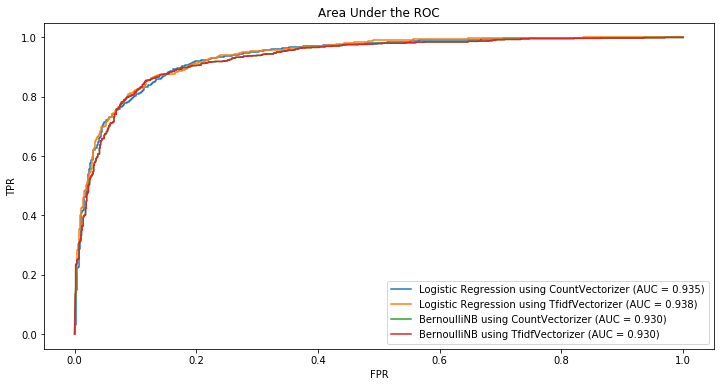

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline

LR = LogisticRegression(solver='lbfgs')
B = BernoulliNB()
#LR, using CountVectorizer
LR.fit(X_train_vc, y_train)
y_pred_LR_vc = LR.predict_proba(X_test_vc)[:,1]
fpr_LR_vc, tpr_LR_vc, thresholds_LR_vc = roc_curve(y_test, y_pred_LR_vc)
roc_auc_LR_vc = roc_auc_score(y_test, y_pred_LR_vc)

#LR, using TfidfVectorizer
LR.fit(X_train_tf, y_train)
y_pred_LR_tf = LR.predict_proba(X_test_tf)[:,1]
fpr_LR_tf, tpr_LR_tf, thresholds_LR_tf = roc_curve(y_test, y_pred_LR_tf)
roc_auc_LR_tf = roc_auc_score(y_test, y_pred_LR_tf)

#B for training data
B.fit(X_train_vc, y_train)
y_pred_B_vc = B.predict_proba(X_test_vc)[:,1]
fpr_B_vc, tpr_B_vc, thresholds_B_vc = roc_curve(y_test, y_pred_B_vc)
roc_auc_B_vc = roc_auc_score(y_test, y_pred_B_vc)

#B for test data
B.fit(X_train_tf, y_train)
y_pred_B_tf = B.predict_proba(X_test_tf)[:,1]
fpr_B_tf, tpr_B_tf, thresholds_B_tf = roc_curve(y_test, y_pred_B_tf)
roc_auc_B_tf = roc_auc_score(y_test, y_pred_B_tf)

fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

ax.plot(fpr_LR_vc,tpr_LR_vc, label= 'Logistic Regression using CountVectorizer'+' (AUC = %0.3f)'% roc_auc_LR_vc)
ax.plot(fpr_LR_tf,tpr_LR_tf, label= 'Logistic Regression using TfidfVectorizer'+' (AUC = %0.3f)'% roc_auc_LR_tf)

ax.plot(fpr_B_vc,tpr_B_vc, label= 'BernoulliNB using CountVectorizer'+' (AUC = %0.3f)'% roc_auc_B_vc)
ax.plot(fpr_B_vc,tpr_B_vc, label= 'BernoulliNB using TfidfVectorizer'+' (AUC = %0.3f)'% roc_auc_B_tf)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Area Under the ROC')
plt.legend(loc="lower right")

**The Logistic Regression model using Tfidf Vectorizer gives the highest AUC (=0.938).**

First of all, Logistic Regression (LR) performs better than Bernoulli Naive Bayes (NB). NB assumes class independence, which means the features are independent given the class they belong ('negative' or 'positive'). However, features in a real data sets or factors in real life are never perfectly independent. They can only be close to conditionally independence in very specific cases. Since NB bases on such a big assumption, it has a higher bias but lower variance compared to logistic regression. In case we have the data set that follows this bias, Naive Bayes could be a better classifier. Furthermore, while both NB and LR are linear classifiers, LR makes a prediction for the probability using a direct functional form where NB figures out how the data was generated given the results. Last but not least, for a large data set, LR performs better because NB reaches its asymptotic faster (O(log n)) than LR model (O(n)). This implies that NB reaches the asymptotic solution for fewer training data than LR and cannot give precise prediction for the remaining data after it reaches the asymptotic threshold *(experiment by Dr. Andrew Ng)*.

Second, Tfidf Vectorizer performs better than Count Vectorizer because it takes into account not only the frequency of one word appearing in the text but also the importance of that word. Tfidf gives more weights for words that are found in this context specifically and are not generally found in all other documents. It implies that these certain words play a role in specifying the context of our text. Applying the same logic, Tfidf punishes words found in our text that are also found in a lot of similar and dissimilar documents. This implies that these words are not specific to our text but are just general terms.

**Interesting finding:**
    
With the Bernoulli model, using Count Vectorizer is the same as using Tfidf Vectorizer. It is because Bernoulli is designed to deal with binary/boolean features. So if Tfidf Vectorizer gives us a value between 0 and 1, and Count Vectorizer gives us the count of the word, Bernoulli will treat all non-zero value as 1. Thus, the inputs coming from these two methods will result in the same prediction in Bernoulli model.

**Check the predictions of the models**

To understand why the model could go wrong, I choose to inspect 5 random cases where the model gives a false negative.

In [9]:
#The model I picked is Logistic Regression with TfidfVectorizer. First, make predictions.
LR.fit(X_train_tf, y_train)
y_pred = LR.predict(X_test_tf)
y_pred_proba = LR.predict_proba(X_test_tf)

# Second, detect incorrect predictions. Display 5 incorrect reviews.
predict = pd.DataFrame(X_test, columns =['Text'])
predict['Class'] = y_test
predict['Predicted_class'] = y_pred
predict['Pred_proba_neg'] = y_pred_proba[:,0]
predict['Pred_proba_pos'] = y_pred_proba[:,1]
predict['Result'] = y_pred - y_test

result = {0: 'True', 1: 'False Positive', -1: 'False Negative'}
predict['Result'] = predict['Result'].map(result)

pd.options.display.max_colwidth = 5000
predict[predict['Result']=='False Negative'].head(5)

,Text,Class,Predicted_class,Pred_proba_neg,Pred_proba_pos,Result
2717,'Yes it was a little low budget but this movie shows love! The only bad things about it was that you can tell the budget on this film would not compare to Waterworld and though the plot was good the film never really tapped into its full potential! Strong performances from everyone and the suspense makes it worthwhile to watch on a rainy night.',1,0,0.506862,0.493138,False Negative
1534,'I saw this movie as a kid on Creature Feature when I lived in New York. It was a pretty creepy movie though not as good as Horror Hotel. I just bought this movie on DVD and it is different from what I remember because in the DVD that I bought there are several scenes where the actors speak in French and/or Italian and no subtitles are provided. Then the other actors respond in English to what was being said. Kind of weird. Also on the DVD box the names of some of the actors are spelled differently than on IMDb. Aside from that this movie is different in that the character of Elsie takes her clothes off and provides a nude shot in one scene and in another scene Julia tries to force Elizabeth (Barbara Steele) to make out with her by pushing her down on the bed and kissing her while Steele resists. That scene existed in the TV version but it was very edited. I wonder if there is any extra footage that could be incorporated into a remastered ultra-edition? It seems sad that some of these old low budget classics have been spliced to bits and sold in all kinds of edited versions. Where are the master tapes and all the unused footage? Aside from the first boring twenty minutes before Allen is delivered to the Castle the rest of the movie is pretty good. There arent too many special effects (but Herberts face after Julia clubs him is a good one). The creepy atmosphere and the strange exotic and seductive look of Barbara Steele make the movie a lot better than it should be. I can honestly say that if Barbara Steele had not been in this film it would be a big zero. She makes the movie a ten!',1,0,0.616167,0.383833,False Negative
7367,'Chris and Andre are two average ordinary teens. Misunderstood by some and picked on by others. But together they stand and all will pay. Together they form The Army of Two. They scheme and plan Zero Day. That day is when they decide to storm their high school and inevitably murder 14 people in cold blood. Told through the tapes that they made Zero Day it is barely a fictionalized telling of the Columbine tragedy. Zero Day is one of those movies that will mess with your head afterwards. The two main actors (Calvin Robertson and Andre Keuck) do such a good job that their characters seem like almost any disenfranchised teen walking the street. Their performances were very believable you kinda liked these guys and that was scary. Shot on video almost totally from the teens perspectives Zero Day feels very real and authentic like you are right there. These kids try to rationalize their actions to the viewer and the actors sell it to you. But be warned it does follow the tragedy from beginning to end and the ending makes be shocking and uneasy for some.',1,0,0.507018,0.492982,False Negative
2982,'A meteor crashes into Crater Lake the heat from the impact causing a prehistoric egg to hatch. Alright so the plot is just trash. But despite its obvious low budget this comes across as one of the most gripping and entertaining monster-on-the-loose films in existence. There are also some good moments of humor. In an age filled so-called monsters which are no more than laughable men-in-rubber-suit creations or lizards dressed up in frills and forced to rip each other to pieces (cheap exploitation-style) its refreshing to discover that the Plesiosaur in this little gem is an excellent Harryhausen-style stop-motion creature. Quite a hard film to find but its worth finding.',1,0,0.506019,0.493981,False Negative
8379,'I wasnt expecting the highest calibre of film-making wi

**False negative - explanation**

These reviews have been classified incorrectly as 'Negative' because they share some negative views about the movie and have 'negative words' captured by our models. The class probability estimations for these instances are very close so in fact our model predicts wrong by only a small percentage. We can see this from looking closely into the 5 chosen instances.

1. In the review #2717, we can easily notice the keywords and phrases that are negative and that can trick our model to think that it's overall a bad review. For example, *'it was a little bit low budget', 'The only bad thing about this movie', 'this film would not compare to','the film never tapped into...'*. We use bigram in our model so the phrases the model can catch are *'low budget', 'bad thing', 'never', etc.,* which represent negativity. The negative words appear more frequently than positive words in this review. For us the primary clue to determine this is a good review lies in the last sentence, which reads *'it was worthwhile to watch'*. Also, by showing the class probability estimation, we can see that the Negative class wins by less than 1%.

2. Similarly, we can also detect negative phrases in the review #1534, which makes our model predicts that it is negative. The phrases are *'it was a pretty creepy movie though not as good as', 'no subtitles are provided', 'Kind of weird', 'it was very edited... remastered ultra-edition', 'these old low budget classics', 'the first boring twenty minutes', 'There arent too many special effects'.* Our bigram model will therefore capture negative phrases like *'pretty creepy', 'no subtitles', 'weird', 'boring', etc.* In fact, negative words/phrases in this review outnumber the positives one, which leads to the probability estimation for 'Negative' is 0.23 higher than that for 'Positive'.  The only clue that helps us know the reviewer's overall positive feelings about this movie lies at the very end – *'She makes the movie a ten!'.* 

3. The review #7367 does not contain a lot of negative views and mainly discuss the plot of the movie. The overall theme of the movie is pretty dark (main characters are bullied and plan on a revenge by murdering 14 people), which could lead to some bad keywords being captured by the model. For example, *'misunderstood', 'cold blood','shocking', 'uneasy', etc.* But again, the probability estimation is wrong by a very small amount (around 0.01).

4. The false-negative case of #2982 is similar to #2717, the review is brief and contains noticeable negative phrases like *'trash', 'obviously', 'low budget', 'cheap exploitation-style', etc.*, which trick our model into classifying this one as a bad review. But again, the reviewer said *'it's worth'* at the very end so it's overall a positive review. The probability estimation in this case is wrong by a very small amount (around 0.01).

5. The false-negative case of #8379 is somewhat similar to #1534 where the negative phrases outnumber the positive ones. Noticeable negative phrases found in this review are *'complete waste of time', 'shaky camera', 'more distracting', 'weak', 'less contrived', 'not great', etc.* But in the end, the review thinks it is *'the most realistic portrayal of.. and neither a bad film'* so it is overall considered a good review. The probability estimations for both classes are somewhat close but the model leans toward classifying it as a 'negative' review.